# Modelling the effect of hyperoxia on the spin-lattice relaxation rate R1 of tissues

<i> Emma Bluemke, Eleanor Stride, Daniel Peter Bulte 
    
Institute of Biomedical Engineering, Department of Engineering Sciences, University of Oxford, UK </i>

----------------------------


This is the accompanying code for our manuscript, "Modelling the effect of hyperoxia on the spin-lattice relaxation rate R1 of tissues", where we present a 3-compartment model for estimating the hyperoxia-induced changes in R1 of tissues depending on B0, SO$_2$, blood volume, hematocrit, oxygen extraction fraction, and changes in blood and tissue PO$_2$. 


<b>Please see the main manuscript for full theory explanation and details.</b>

----------------------------


### The model can be conceptually separated into 4 steps: 

<b>Step 1. Calculate PO$_2$ along the capillary.</b> The ΔR1B,deOx and ΔR1T and ΔR1B,Ox are all related by a calculation of the SO$_2$ or PO$_2$ along the capillary length, which is determined by the arterial PO$_2$ and the OEF of the tissue.

<b>Step 2. Calculate ΔPO$_2$ of each compartment.</b> Knowing the PO$_2$ along the capillary allows the ΔPO$_2$ from oxygen administration to be calculated in the blood and tissue compartments, using the Krogh tissue cylinder to model the oxygen diffusion into the tissue, and the set OEF is related to the tissue oxygen consumption rate. The Krogh tissue cylinder radius is calculated from the set blood volume.

<b>Step 3. Calculate ΔR1 of each compartment.</b> Knowing the ΔPO$_2$ in each compartment allows the ΔR1T to be calculated using the r1Ox (calculated with respect to B0 using a model published by Bluemke et al.(https://doi.org/10.1002/nbm.4625)); the ΔR1 of each blood compartment to be calculated using a Blood R1 model published by Bluemke et al. (https://doi.org/10.1002/jmri.27938). 

<b>Step 4. Calculate ΔR1 of voxel.</b> Once the ΔR1 in each compartment is calculated, we use the set blood volume fraction (BV) to calculate the resulting ΔR1 of the voxel (ΔR1voxel). 

## Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import scipy
import math
import random
from scipy.optimize import least_squares
import pandas as pd
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.metrics import mean_squared_error


# PART 1: Defining all the functions

FYI These shouldn't give you any output when you run the cells, because this section just defines the functions.  

## 1. Function for calculating SO2 along capillary from OEF and CaO2

#### INPUT VARIABLES: PaO2, OEF
#### CONSTANTS: L, Nr, P50, n, $c_0$, $\alpha_p$
#### OUTPUTS: SO2 along capillary, PO2 along capillary



In [2]:
def SO2cap_from_OEF(PaO2):
    
    SaO2=(PaO2**n)/((PaO2**n)+P50**n)
    
    CaO2=alphap*PaO2+Hct*c0*(PaO2**n)/((PaO2**n)+P50**n)
    
    CvO2=CaO2*(1-OEF)
    

    halfL=L/2
    length=np.linspace(0,L*10000,100)
    z=length/10000
    
    Scapmean=SaO2*(1-(OEF/2))
    Cmean=(CaO2+CvO2)/2
    
    slopeC=(Cmean-CaO2)/halfL
    
    slopeS=-SaO2*OEF/L
    so2_along_cap=SaO2+slopeS*z
    
    C2_along_cap=CaO2+slopeC*z
    
    po2_along_cap=((so2_along_cap*(P50**n))/(1-so2_along_cap))**(1/n)
    
    C_along_cap=alphap*po2_along_cap+Hct*c0*so2_along_cap
    
    return(so2_along_cap,po2_along_cap,C_along_cap,C2_along_cap)


# so2_along_cap,po2_along_cap,C_along_cap,C2_along_cap=SO2cap_from_OEF(PaO2)


## 2. Function for calculating $R_t$ (Krogh tissue radius) from blood volume in the voxel

#### INPUT VARIABLES: % Blood volume (0-1 fraction)
#### CONSTANTS: Rc, Voxel width and volume (1mm^3)
#### OUTPUTS: Rt

In [3]:
def Rt_from_BV():
    voxel_volume=1e-9 #(m^3)= 1mm^3
    
    Ncap=(BV*voxel_volume)/(L*math.pi*(Rc**2))
    
    voxel_width=voxel_volume**(1/3)
    
    Rt=(voxel_width)/(2*(np.sqrt(Ncap)))
    
    return(Rt)
    
# Rt=Rt_from_BV()

## 3. Function for calculating M0 (oxygen consumption rate) from OEF

$\frac{OEF*Hct*CHb*v}{L*(Rt^2-Rc^2)}=M_0	$

#### INPUT VARIABLES: OEF, Rt
#### CONSTANTS: L, Nr, P50, n, Hct, CHb, v, Rc
#### OUTPUTS: M0



In [4]:
def calc_M0():
    SaO2=np.max(so2_along_cap_air)
    M0_output=(SaO2*OEF*Hct*CHb*v)/(L*(Rt**(2)+Rc**(2)))
    
    M0=M0_output/1e13
    #print("M0 = "+str(M0))

    return(M0)

# M0=calc_M0(so2_along_cap,OEF,Rt,L,Nr,P50,n,Hct,CHb,v,Rc)

## 4. Function for Calculating Tissue PO2 ("Into Tissue" Dimension), including PO2-dependent M0


#### INPUT VARIABLES: PO2 along capillary, M0, Rt (all already calculated)
#### CONSTANTS: K, Rc, Nr,Nz
#### OUTPUTS: 2D matrix of PO2 into the tissue & along capillary "po2_r_z_list", and the mean PO2 in the tissue

In [5]:
def po2_into_tissue(po2_along_cap_air,po2_along_cap_ox):
    
    plt.style.use('seaborn')
    
    ############ OXYGEN SECTION ##############
    
    po2_along_cap=po2_along_cap_ox
    
    
    r_list = np.linspace(Rc,Rt,Nr)
    pcap_list=po2_along_cap
    po2_r_z_list=np.zeros((Nr,Nz))
    

    sns.set(font_scale=1.3)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for z in range(0,Nz):
        po2_cap=pcap_list[z]
        M=(M0*po2_cap)/(po2_cap+Pcrit)


        for j in range(0,Nr):
            r=r_list[j]

            
            po2_r=po2_cap+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
            M=(M0*po2_r)/(po2_r+Pcrit)
            
            po2_r_z_list[z,j]=po2_r
            
    
        plt.plot(r_list,po2_r_z_list[z],label=np.round(po2_cap))
    colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0.1, 1,len(ax.lines))]
    for i,j in enumerate(ax.lines):
        j.set_color(colors[i])
    
    plt.title('Tissue PO$_2$ Levels per Radius into Tissue \n Varied Capillary PO2 Levels \n Gas = O$_2$')
    plt.xlabel('Radius into tissue (m)')
    plt.ylabel('PO$_2$ (mmHg)')
    plt.show()

    #plt.legend(fontsize=9,bbox_to_anchor=(1, 1))

    
    
    ### MAKE SURF PLOT
    import matplotlib.colors as colors


    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    cmap = plt.get_cmap('cool')
    new_cmap = truncate_colormap(cmap, 0.2, 1)

    # Make data.
    X = np.linspace(Rc,Rt,Nr)
    Y = np.linspace(0, L, Nz)
    X, Y = np.meshgrid(X, Y)
    Z=po2_r_z_list

    sns.set(font_scale=1)
    sns.set_style("whitegrid")


    fig = plt.figure()
    plt.rcParams["figure.figsize"] = [16,9]
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                           linewidth=0.1,alpha=0.7)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5,aspect=10)

    plt.title('Tissue PO$_2$ Levels \n Gas = O$_2$')

    #ax.set_ylabel('cap z (m)')
    ax.set_xlabel('tiss r (m)')
    ax.set_zlabel('PO$_2$ (mmHg)')
    ax.view_init(30, -30)
    ax.set_zlim3d(0,np.max(po2_r_z_list)) 
    plt.show()
    
    sns.set(font_scale=1.3)
    plt.style.use('seaborn')
    mean_Tpo2_ox=np.mean(po2_r_z_list)
    po2_r_z_list_ox=po2_r_z_list
    
    
    ############ AIR SECTION ##############
    
    po2_along_cap=po2_along_cap_air

    r_list = np.linspace(Rc,Rt,Nr)
    pcap_list=po2_along_cap
    po2_r_z_list=np.zeros((Nr,Nz))
    

    sns.set(font_scale=1.3)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    
    for z in range(0,Nz):
        po2_cap=pcap_list[z]
        M=(M0*po2_cap)/(po2_cap+Pcrit)

        for j in range(0,Nr):
            r=r_list[j]

            
            po2_r=po2_cap+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
            M=(M0*po2_r)/(po2_r+Pcrit)
            po2_r_z_list[z,j]=po2_r
            
    
        plt.plot(r_list,po2_r_z_list[z],label=np.round(po2_cap))
    colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0.1, 1,len(ax.lines))]
    for i,j in enumerate(ax.lines):
        j.set_color(colors[i])
    
    plt.title('Tissue PO$_2$ Levels per Radius into Tissue \n Varied Capillary PO$_2$ Levels \n Gas = AIR')
    plt.xlabel('Radius into tissue (m)')
    plt.ylabel('PO$_2$ (mmHg)')
    plt.show()

    #plt.legend(fontsize=9,bbox_to_anchor=(1, 1))
    


    ### MAKE SURF PLOT
    import matplotlib.colors as colors


    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    cmap = plt.get_cmap('cool')
    new_cmap = truncate_colormap(cmap, 0.2, 1)

    # Make data.
    X = np.linspace(Rc,Rt,Nr)
    Y = np.linspace(0, L, Nz)
    X, Y = np.meshgrid(X, Y)
    Z=po2_r_z_list

    sns.set(font_scale=1)
    sns.set_style("whitegrid")


    fig = plt.figure()
    plt.rcParams["figure.figsize"] = [16,9]
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                           linewidth=0.1,alpha=0.7)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5,aspect=10)

    plt.title('Tissue PO$_2$ Levels \n Gas = AIR')

    #ax.set_ylabel('cap z (m)')
    ax.set_xlabel('tiss r (m)')
    ax.set_zlabel('PO$_2$ (mmHg)')
    ax.view_init(30, -30)
    ax.set_zlim3d(0,np.max(po2_r_z_list)) 
    plt.show()
    
    sns.set(font_scale=1.3)
    plt.style.use('seaborn')
    mean_Tpo2_air=np.mean(po2_r_z_list)
    po2_r_z_list_air=po2_r_z_list
    
    return(po2_r_z_list_air,mean_Tpo2_air,po2_r_z_list_ox,mean_Tpo2_ox)

# po2_r_z_list,mean_Tpo2=po2_into_tissue(po2_along_cap)

In [6]:
def po2_into_tissue_NOFIG(po2_along_cap,gas):

    r_list = np.linspace(Rc,Rt,Nr)
    pcap_list=po2_along_cap
    po2_r_z_list=np.zeros((Nr,Nz))
   
    for z in range(0,Nz):
        po2_cap=pcap_list[z]
        M=(M0*po2_cap)/(po2_cap+Pcrit)

        for j in range(0,Nr):
            r=r_list[j]

            
            po2_r=po2_cap+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
            M=(M0*po2_r)/(po2_r+Pcrit)
            po2_r_z_list[z,j]=po2_r

    
    
    mean_Tpo2=np.mean(po2_r_z_list)
    
    
    return(po2_r_z_list,mean_Tpo2)

# po2_r_z_list,mean_Tpo2=po2_into_tissue(po2_along_cap)

## 5. Function for estimating r1Ox with respect to B0

$ r1Ox = \frac{C_1}{1+C_2*B0^2} + C_3 + C_{Temp}*T$


#### INPUT VARIABLE: B0

#### CONSTANTS: Temp,C1,C2,C3,CTemp

#### OUTPUT: r1Ox for tissue

In [7]:
def r1Ox_func():
    
    # constants from r1Ox model

    C1=4.87
    C2=1.99
    C3=0.844
    CTemp=0.0323

    r1Ox_tissue_unconverted=C1/(1+(C2)*(B0**2)) +C3 +CTemp*Temp 
    r1Ox_tissue=r1Ox_tissue_unconverted*10**(-4)
    return(r1Ox_tissue)


# r1Ox_tissue=r1Ox_func()



## 6. Function for calculating ΔR1Tissue from ΔPO2

$\Delta R1_{tissue}=r1Ox*\Delta PO2$


#### INPUT VARIABLES: ΔPO2 in tissue (PO2oxygen-PO2air), r1Ox_tissue
#### CONSTANTS: none
#### OUTPUTS: ΔR1 in tissue (R1oxygen-R1air)

In [8]:
def calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue):
    delta_R1_tissue=r1Ox_tissue*delta_po2_tissue
    
    return(delta_R1_tissue)

# delta_R1_tissue=calc_delta_R1_tissue(delta_po2,r1Ox_tissue)

## 8.  Function for calculating ΔR1blood 

$ΔR1blood = R1blood_{oxygen} - R1blood_{air}$


### Inner Function for estimating R1blood w.r.t B0, Hct, and PO2

$ R1blood(Hct,PO2) = fe*(R1eox + r1deoxhyHb*[Hb]*(1-\frac{PO2^n}{PO2^n + P50^n})) + (1-fe)*(R1p+r1pox*PO2)$

Where:

$fe=\frac{0.7*Hct}{(0.7*Hct)+0.95*(1-Hct)}$

$R1eox(B0)=bR1eox+mR1eox*B0$

$r1deoxyHb(B0)=br1deoxyHb+mr1deoxyHb*B0$

$R1p(B0)=bR1p+mR1p*B0$

$r1pox(B0,Hct)=br1pox+mr1pox*B0+mr1poxHct*Hct$



#### INPUT VARIABLES: PO2 oxygen, PO2 air

#### CONSTANTS: Hct, B0, Hb, n, P50, bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct 

#### OUTPUT: ΔR1blood (oxygen-air)

In [9]:
def calc_delta_R1_blood(po2_air,po2_oxygen):
    


    def R1blood_func(po2):
        Hb= 5.15

        bR1eox= 1.237
        mR1eox= -0.0825
        br1deoxyHb= 0.102
        mr1deoxyHb= -0.00688
        bR1p= 0.332
        mR1p= 0
        br1pox= 0.000570
        mr1pox= -3.86e-05


        fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
        R1eox=bR1eox+mR1eox*B0
        r1deoxyHb=br1deoxyHb+mr1deoxyHb*B0
        R1p=bR1p+mR1p*B0
        r1pox=br1pox+mr1pox*B0
        so2=(po2**n)/((po2**n)+(P50**n))

        R1_blood_result=fw*(R1eox + (r1deoxyHb*Hb*(1-so2))) + (1-fw)*(R1p+r1pox*po2)
        
        return(R1_blood_result)
    
    R1blood_air=R1blood_func(po2_air)
    R1blood_oxygen=R1blood_func(po2_oxygen)
    
    delta_R1_blood=R1blood_oxygen-R1blood_air
    
    return(delta_R1_blood)
    


# delta_R1_blood=calc_delta_R1_blood(po2_air,po2_oxygen)


## 9. Function for Calculating ΔR1voxel

$ΔR1voxel=(0.5*BV)*ΔR1arterial +(1-BV)*ΔR1tissue +(0.5*BV)*ΔR1venous$


#### INPUT VARIABLES: $ΔR1blood_{arterial}$, $ΔR1blood_{venous}$, ΔR1tissue, Blood volume (BV)

#### CONSTANTS:  none

#### OUTPUT: ΔR1voxel (oxygen-air)

In [10]:
def calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue):
        art_fraction=0.5*BV
        ven_fraction=0.5*BV
        tiss_fraction=1-BV
    
        
        delta_R1_voxel=(art_fraction)*delta_R1_blood_arterial+ (ven_fraction)*delta_R1_blood_venous + (tiss_fraction)*delta_R1_tissue
        

    

    ###################################################
    
    
        deltaR1_df = pd.DataFrame({'Compartment': ['Arterial', 'Tissue', 'Venous'],
                   'DeltaR1': [delta_R1_blood_arterial,delta_R1_tissue,delta_R1_blood_venous],
                   'DeltaPO2': [PaO2_ox-PaO2_air,delta_po2_tissue,PvO2_ox-PvO2_air],
                    'VolumeFraction': [art_fraction,tiss_fraction,ven_fraction],
                    'WeightedDelta': [(art_fraction)*delta_R1_blood_arterial,(tiss_fraction)*delta_R1_tissue,(ven_fraction)*delta_R1_blood_venous ]})
        
        plt.figure()
        sns.set(font_scale=1.6)
        graph=sns.barplot(x=deltaR1_df.Compartment,y=deltaR1_df.DeltaR1,palette='RdYlBu')
        graph.axhline(0,color='black',linewidth=2)
        plt.title('$\Delta R1$ in Each Compartment')
        plt.show()

        
        pie, ax = plt.subplots(figsize=[10,6])
        labels = deltaR1_df.Compartment
        plt.pie(x=deltaR1_df.VolumeFraction,autopct="%.1f%%",labels=labels,colors=['indianred','lightgoldenrodyellow','lightblue'])
        plt.title('Volume Fraction Per Compartment in Voxel')
        plt.show()

        sns.set(font_scale=1.6)
        plt.figure()
        graph=sns.barplot(x=deltaR1_df.Compartment,y=deltaR1_df.WeightedDelta,palette='RdYlBu')
        plt.title('Resulting Weighted $\Delta R1$ \n Per Compartment in Voxel')
        graph.axhline(delta_R1_voxel,linestyle='dashed',color='black',linewidth=2)
        graph.axhline(0,color='black',linewidth=2)
        plt.text(-0.3,delta_R1_voxel-0.0005,'$ΔR1_{Voxel}$',color='black')
        plt.show()
        
        return(delta_R1_voxel)
    
# delta_R1_voxel=calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
    


In [11]:
def calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue):
        art_fraction=0.5*BV
        ven_fraction=0.5*BV
        tiss_fraction=1-BV
    
        
        delta_R1_voxel=(art_fraction)*delta_R1_blood_arterial+ (ven_fraction)*delta_R1_blood_venous + (tiss_fraction)*delta_R1_tissue
        

        return(delta_R1_voxel)
    
# delta_R1_voxel=calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
    

# PART 2: Set Your Constants

Please see our main manuscript for the sources of these constants.

In [12]:
c0 = 0.5 #mlO2 ml^-1
alphap = 3.1e-5 # mlO2 ml^-1 mmHg^-1
n=2.7
P50=37 #mmHg

Rc = 3.5e-6; # [m] capillary radius - 5 to 10 micrometres (μm) in diameter
L = 0.001; # [m] Length of capillary segment the average length of a capillary is about ~600 microns
v = 0.00079 # capillary velocity [m/s]
D = 2.41e-9 # [m^2/s] diffusivity of O2 in tumour tissue 
k = 2.8e-5 # [mlO2/mmHg] solubility of O2 in tumour tissue 
K = D*k

CHb= 1.36 #mlO2/g


# PART 3: Calling the functions

This is where the action happens.

## Example: Calling the functions once

This section is an example of how to call the above functions and make them give you your output and several plots.

The plots are useful to make sure nothing is going wrong.

1.3871645541621043e-05


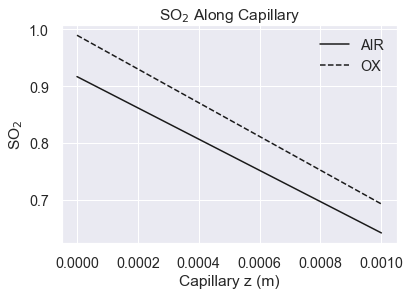

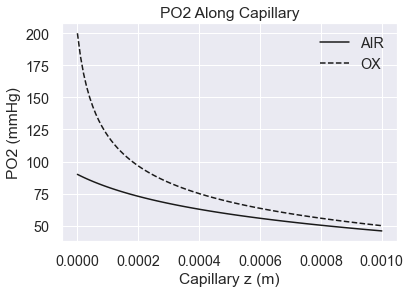

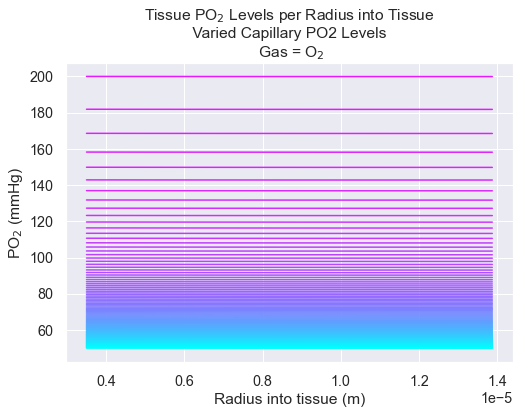

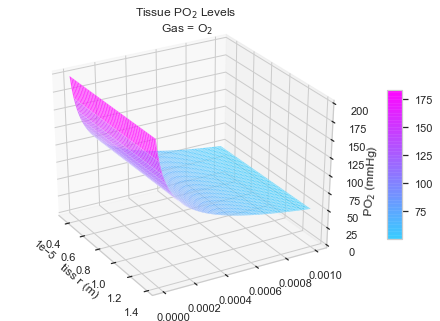

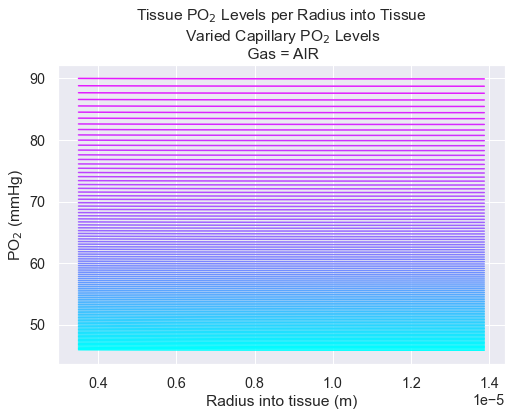

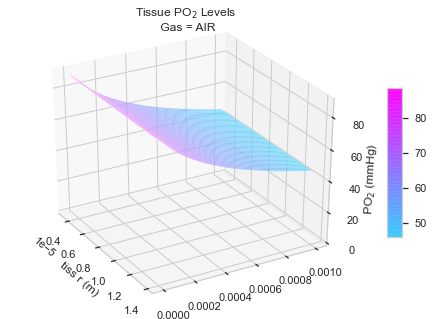

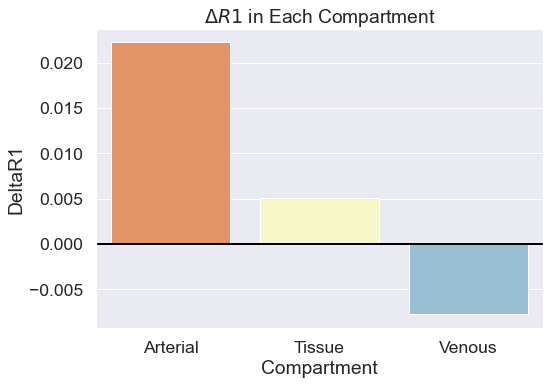

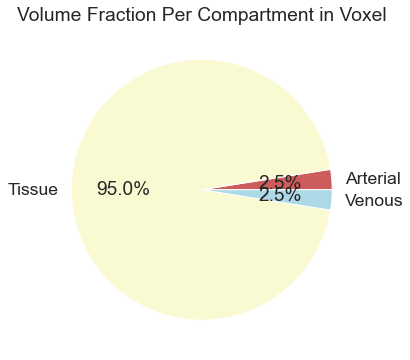

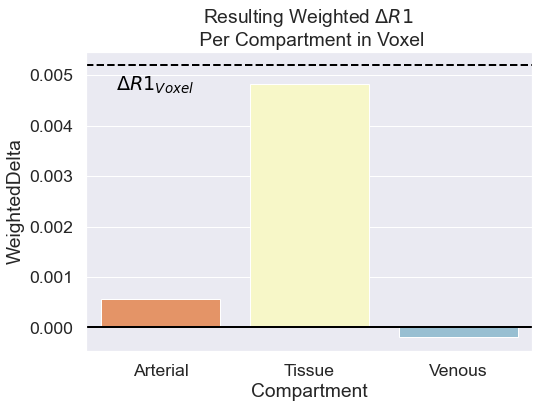

6.497226181967317e-05


In [13]:
%matplotlib inline
sns.set(font_scale=1.3)

## Variables you can alter:
OEF=0.3
BV=0.05
B0=1.5
Temp=37
Hct=0.45
Pcrit=3 #or 0.35 mmHg 

PaO2_air=90 # mmHg
PaO2_ox=200 # mmHg

Nr=100
Nz=100


###################################################

# calculate Rt
Rt=Rt_from_BV()
print(Rt)

###################################################
# calculate so2 along capillary ON AIR
so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)

# calculate so2 along capillary ON OXYGEN
so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)

plt.figure()
z_along_cap=np.linspace(0,L,100)
plt.plot(z_along_cap,so2_along_cap_air,'k',label='AIR')
plt.plot(z_along_cap,so2_along_cap_ox,'k--',label='OX')
plt.legend()
plt.title('SO$_2$ Along Capillary')
plt.ylabel('SO$_2$')
plt.xlabel('Capillary z (m)')
plt.show()

plt.figure()
z_along_cap=np.linspace(0,L,100)
plt.plot(z_along_cap,po2_along_cap_air,'k',label='AIR')
plt.plot(z_along_cap,po2_along_cap_ox,'k--',label='OX')
plt.legend()
plt.title('PO2 Along Capillary')
plt.ylabel('PO2 (mmHg)')
plt.xlabel('Capillary z (m)')
plt.show()

# calculate PvO2 on air and oxygen
PvO2_air=np.min(po2_along_cap_air)
PvO2_ox=np.min(po2_along_cap_ox)

###################################################

# calculate M0 - uses only ON AIR values
M0=calc_M0()

###################################################

# calculate mean po2 in tissue ON AIR and ON OXYGEN
po2_r_z_list_air,mean_Tpo2_air,po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue(po2_along_cap_air,po2_along_cap_ox)


# calculate DELTA PO2 of TISSUE (oxygen - air)
delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air

###################################################

# calculate r1Ox for tissue
r1Ox_tissue=r1Ox_func()

# calculate ΔR1tissue
delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)

###################################################

# calculate ΔR1arterial
delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)

# calculate ΔR1venous
delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)


delta_R1_voxel=calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
print(M0)




## Example: How you can calculate many ΔR1s for a range of variable values (i.e. for different types of tissue)

There are many ways to do this, but here's some example code to show how you would create a loop and receieve the output. If you run this, you'll collect a delta R1 for each possible combination of variables that are in the set reasonable range for that tissue type.

Note that if you're running loops like this, you want to use the versions of the functions that do NOT spit out plots, otherwise it gets crazy. 

In [14]:
## 1.5T, MALE and FEMALE separate

PaO2_air=90 # mmHg
PaO2_ox=600

B0=1.5

Hct_list=np.linspace(0.36,0.48,10) ## FEMALE
nHct=len(Hct_list)

## Tumour tissue, less vascular

OEF_list=np.linspace(0.24,0.44,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.047,0.059,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)


mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel

flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_TUMOUR_lowbv_1.5T_female.csv", flattened_voxellist, delimiter=",")


## Tumour tissue, more vascular

OEF_list=np.linspace(0.24,0.44,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.09,0.17,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel
                
flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_TUMOUR_highbv_1.5T_female.csv", flattened_voxellist, delimiter=",")

## repeating for low-metabolism tumour type

OEF_list=np.linspace(0.02,0.20,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.047,0.059,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel

flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_TUMOUR_lowMETAB_1.5T_female.csv", flattened_voxellist, delimiter=",")



## VASCULAR PERIPHERY

OEF_list=np.linspace(0.24,0.44,20)
nOEF=len(OEF_list)

BV=1.0
nBV=1
iBV=0

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iPcrit in range(0,len(Pcrit_list)):
            Pcrit=Pcrit_list[iPcrit]

            Rt=Rt_from_BV()
            print(Rt)
            so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
            so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
            PvO2_air=np.min(po2_along_cap_air)
            PvO2_ox=np.min(po2_along_cap_ox)
            M0=calc_M0()
            po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
            po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
            delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
            r1Ox_tissue=r1Ox_func()
            delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
            delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
            delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
            delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
            mega_delta_R1voxel_list[iHct,iOEF,iPcrit]=delta_R1_voxel

flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_VASCPERIPHERY_1.5T_female.csv", flattened_voxellist, delimiter=",")

## NECROTIC

OEF_list=np.linspace(0.02,0.05,20)
nOEF=len(OEF_list)

BV=0.0001
nBV=1
iBV=0

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)



mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iPcrit in range(0,len(Pcrit_list)):
            Pcrit=Pcrit_list[iPcrit]

            Rt=Rt_from_BV()
            print(Rt)
            so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
            so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
            PvO2_air=np.min(po2_along_cap_air)
            PvO2_ox=np.min(po2_along_cap_ox)
            M0=calc_M0()
            po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
            po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
            delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
            r1Ox_tissue=r1Ox_func()
            delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
            delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
            delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
            delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
            mega_delta_R1voxel_list[iHct,iOEF,iPcrit]=delta_R1_voxel
            
flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_NECROTIC_1.5T_female.csv", flattened_voxellist, delimiter=",")

## BRAIN TISSUE

OEF_list=np.linspace(0.31,0.37,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.02,0.07,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(1,4,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel
                
flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_NORMAL_brain_1.5T_female.csv", flattened_voxellist, delimiter=",")

############## MALE ############

Hct_list=np.linspace(0.41,0.50,10) ## MALE
nHct=len(Hct_list)

## Tumour tissue, less vascular

OEF_list=np.linspace(0.24,0.44,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.047,0.059,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)


mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel

flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_TUMOUR_lowbv_1.5T_male.csv", flattened_voxellist, delimiter=",")


## Tumour tissue, more vascular

OEF_list=np.linspace(0.24,0.44,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.09,0.17,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel
                
flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_TUMOUR_highbv_1.5T_male.csv", flattened_voxellist, delimiter=",")

## repeating for low-metabolism tumour type

OEF_list=np.linspace(0.02,0.20,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.047,0.059,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel

flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_TUMOUR_lowMETAB_1.5T_male.csv", flattened_voxellist, delimiter=",")



## VASCULAR PERIPHERY

OEF_list=np.linspace(0.24,0.44,20)
nOEF=len(OEF_list)

BV=1.0
nBV=1
iBV=0

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iPcrit in range(0,len(Pcrit_list)):
            Pcrit=Pcrit_list[iPcrit]

            Rt=Rt_from_BV()
            print(Rt)
            so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
            so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
            PvO2_air=np.min(po2_along_cap_air)
            PvO2_ox=np.min(po2_along_cap_ox)
            M0=calc_M0()
            po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
            po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
            delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
            r1Ox_tissue=r1Ox_func()
            delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
            delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
            delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
            delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
            mega_delta_R1voxel_list[iHct,iOEF,iPcrit]=delta_R1_voxel

flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_VASCPERIPHERY_1.5T_male.csv", flattened_voxellist, delimiter=",")

## NECROTIC

OEF_list=np.linspace(0.02,0.05,20)
nOEF=len(OEF_list)

BV=0.0001
nBV=1
iBV=0

Pcrit_list=np.linspace(0.5,2,5)
nPcrit=len(Pcrit_list)



mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iPcrit in range(0,len(Pcrit_list)):
            Pcrit=Pcrit_list[iPcrit]

            Rt=Rt_from_BV()
            print(Rt)
            so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
            so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
            PvO2_air=np.min(po2_along_cap_air)
            PvO2_ox=np.min(po2_along_cap_ox)
            M0=calc_M0()
            po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
            po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
            delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
            r1Ox_tissue=r1Ox_func()
            delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
            delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
            delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
            delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
            mega_delta_R1voxel_list[iHct,iOEF,iPcrit]=delta_R1_voxel
            
flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_NECROTIC_1.5T_male.csv", flattened_voxellist, delimiter=",")

## BRAIN TISSUE

OEF_list=np.linspace(0.31,0.37,20)
nOEF=len(OEF_list)

BV_list=np.linspace(0.02,0.07,5)
nBV=len(BV_list)

Pcrit_list=np.linspace(1,4,5)
nPcrit=len(Pcrit_list)

mega_delta_R1voxel_list=np.zeros((nHct,nOEF,nBV,nPcrit))

for iHct in range(0,len(Hct_list)):
    Hct=Hct_list[iHct]
    for iOEF in range(0,len(OEF_list)):
        OEF=OEF_list[iOEF]
        for iBV in range(0,len(BV_list)):
            BV=BV_list[iBV]
            for iPcrit in range(0,len(Pcrit_list)):
                Pcrit=Pcrit_list[iPcrit]

                Rt=Rt_from_BV()
                print(Rt)
                so2_along_cap_air,po2_along_cap_air,C_along_cap_air,C2_along_cap_air=SO2cap_from_OEF(PaO2_air)
                so2_along_cap_ox,po2_along_cap_ox,C_along_cap_ox,C2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)
                PvO2_air=np.min(po2_along_cap_air)
                PvO2_ox=np.min(po2_along_cap_ox)
                M0=calc_M0()
                po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue_NOFIG(po2_along_cap_air,'AIR')
                po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue_NOFIG(po2_along_cap_ox,'OXYGEN')
                delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air
                r1Ox_tissue=r1Ox_func()
                delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)
                delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)
                delta_R1_blood_venous=calc_delta_R1_blood(PvO2_air,PvO2_ox)
                delta_R1_voxel=calc_delta_R1_voxel_NOFIG(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)
                mega_delta_R1voxel_list[iHct,iOEF,iBV,iPcrit]=delta_R1_voxel
                
flattened_voxellist=mega_delta_R1voxel_list.flatten('F')
np.savetxt("flat_deltaR1vox_NORMAL_brain_1.5T_male.csv", flattened_voxellist, delimiter=",")


1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.276988479

1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06


8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06


8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06


8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06


9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1

9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0

1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.52

1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.

7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06


8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06


8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06


9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0

1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.52

7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06


1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.387164554

1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.310747299

1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.387164554

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.310747299

1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.387164554

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.347333320

1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.387164554

3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.101794239

3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.101794239

3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.000310179

0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.000310179

0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.000310179

1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.462199

1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.

1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.293537

1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720

1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1

1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.462199

1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.7

2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723

1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.72056

1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.

1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.293537

1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.7

2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723

1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.462199

1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.387164554

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.310747299

1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.387164554

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.387164554

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.310747299

1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.276988479

1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.347333320

8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06


9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0

1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.52

1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7

7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06


7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06


8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06


8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06


9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.

9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.03

1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.52

1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06


7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
8.008798287557982e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
7.522956045104935e-06
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
1.0339314130282181e-05
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
9.352261516299753e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06
8.602829365352714e-06


1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.387164554

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.347333320

1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.430750993

1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.347333320

1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.347333320

1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.276988479

1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.387164554

1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.310747299

1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3871645541621043e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3473333202207697e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.3107472992273986e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.2769884794098774e-05
1.4307509932199014e-05
1.4307509932199014e-05
1.430750993

3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.101794239

3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.101794239

3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.1017942390846542e-06
3.101794239

0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.000310179

0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.000310179

0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.00031017942390846546
0.000310179

1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.462199

1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.

2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.293537

1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.7205

1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1

1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.462199

1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.

1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.293537

1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720

1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.

1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.293537

1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.7

2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.17236

1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.4621998268680844e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.2935376165766936e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
1.1723680249586882e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
2.193299740302126e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.720565873070543e-05
1.462199